In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(30), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
data_dir = 'dataset'

In [4]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
resnet18 = models.resnet18(pretrained=True)

In [8]:
class SimCLRModel(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLRModel, self).__init__()
        self.base_model = base_model
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  
        
        self.projection_head = nn.Sequential(
            nn.Linear(512, 512),  
            nn.ReLU(),
            nn.Linear(512, projection_dim)  
        )

        self.classification_head = nn.Linear(512, 3)

    def forward(self, x, mode='contrastive'):
        features = self.base_model(x)  
        features = features.view(features.size(0), -1)  
        
        if mode == 'contrastive':
            projection = self.projection_head(features)  
            return projection
        
        elif mode == 'classification':
            return self.classification_head(features)

In [9]:
simclr_model = SimCLRModel(resnet18)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simclr_model.to(device)

SimCLRModel(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = nn.functional.normalize(z1, p=2, dim=1)
        z2 = nn.functional.normalize(z2, p=2, dim=1)

        similarity_matrix = torch.matmul(z1, z2.T) / self.temperature

        labels = torch.arange(similarity_matrix.size(0)).to(device)

        loss = nn.functional.cross_entropy(similarity_matrix, labels)
        return loss

In [12]:
loss_fn = NTXentLoss(temperature=0.5)

In [13]:
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)

In [14]:
num_epochs = 8
for epoch in range(num_epochs):
    simclr_model.train()
    total_loss = 0.0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)

        view1 = images
        view2 = torch.stack([
            transform(Image.fromarray(img.permute(1, 2, 0).cpu().numpy().astype(np.uint8))) 
            for img in images
        ])

        projection1 = simclr_model(view1, mode='contrastive')
        projection2 = simclr_model(view2, mode='contrastive')

        loss = loss_fn(projection1, projection2)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/8], Loss: 2.7493
Epoch [2/8], Loss: 2.5188
Epoch [3/8], Loss: 2.4391
Epoch [4/8], Loss: 2.3919
Epoch [5/8], Loss: 2.1707
Epoch [6/8], Loss: 2.1327
Epoch [7/8], Loss: 2.1418
Epoch [8/8], Loss: 2.0720


In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-4)

In [17]:
for epoch in range(5):  
    simclr_model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
      
        outputs = simclr_model(images, mode='classification')
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Fine-tuning Epoch [{epoch+1}/2], Loss: {avg_loss:.4f}")

Fine-tuning Epoch [1/2], Loss: 0.8934
Fine-tuning Epoch [2/2], Loss: 0.5105
Fine-tuning Epoch [3/2], Loss: 0.4340
Fine-tuning Epoch [4/2], Loss: 0.3223
Fine-tuning Epoch [5/2], Loss: 0.2916


In [18]:
simclr_model.eval()
all_train_labels = []
all_train_predictions = []
all_val_labels = []
all_val_predictions = []

In [19]:
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = simclr_model(images, mode='classification')
        _, predicted = torch.max(outputs, 1)
        
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

train_accuracy = np.sum(np.array(all_train_labels) == np.array(all_train_predictions)) / len(all_train_labels)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9145


In [20]:
print("\nClassification Report on Training Data:")
print(classification_report(all_train_labels, all_train_predictions))


Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        39
           1       0.94      0.90      0.92        97
           2       0.89      0.95      0.92        98

    accuracy                           0.91       234
   macro avg       0.92      0.91      0.91       234
weighted avg       0.92      0.91      0.91       234



In [21]:
cm = confusion_matrix(all_train_labels, all_train_predictions)

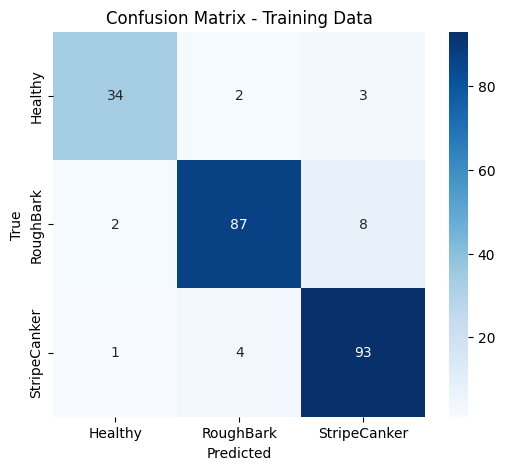

In [22]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'RoughBark', 'StripeCanker'], yticklabels=['Healthy', 'RoughBark', 'StripeCanker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Training Data')
plt.show()

In [23]:
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = simclr_model(images, mode='classification')
        _, predicted = torch.max(outputs, 1)
        
        all_val_labels.extend(labels.cpu().numpy())
        all_val_predictions.extend(predicted.cpu().numpy())

val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_predictions)) / len(all_val_labels)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.9322


In [24]:
print("\nClassification Report on Validation Data:")
print(classification_report(all_val_labels, all_val_predictions))


Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.84      0.91        25
           2       0.88      1.00      0.93        28

    accuracy                           0.93        59
   macro avg       0.96      0.95      0.95        59
weighted avg       0.94      0.93      0.93        59



In [25]:
cm2 = confusion_matrix(all_val_labels, all_val_predictions)

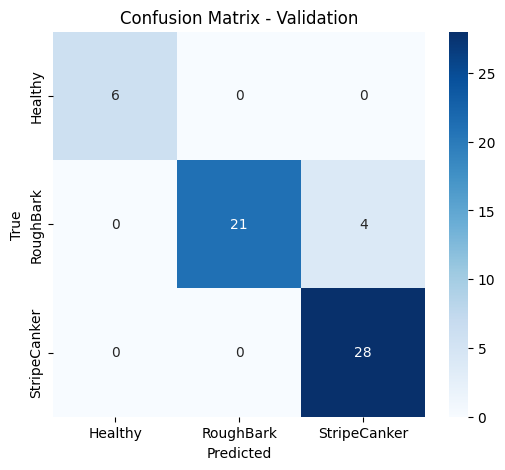

In [26]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'RoughBark', 'StripeCanker'], yticklabels=['Healthy', 'RoughBark', 'StripeCanker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation')
plt.show()

In [27]:
model_save_path = 'simclr_model.pth'  
torch.save(simclr_model.state_dict(), model_save_path)